# Imports

In [437]:
import sys, os

from math import log10
from numpy import array, pi

import pandas as pd
import numpy as np
from numpy import concatenate
from bisect import bisect_left
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from hist import Hist
import hist

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import zero_one_loss, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.base import clone
# algorithms:
from sklearn.tree import export_graphviz, DecisionTreeClassifier#, plot_tree, export_text # Available in later versions
#import graphviz

# Setup plotting

In [438]:
plt.rcParams['figure.figsize'] = [10, 8]
font = {'family' : 'serif','weight' : 'normal','size'   : 22}
plt.rc('font', **font)

SE_size = 47.07

# Parameters

# Get data

In [527]:
df1 = pd.read_csv('tritium_ML_data.csv')
df2 = pd.read_csv('bg_sr1_MLtrain.csv')

df = pd.concat([df1,df2], ignore_index=True)
df = df.drop('Unnamed: 0', axis = 1)
df.head()
#df.type[0]

,runID,eventID,area,max_pulse_height,ext_elec,x,y,r,label,type,dt10_05,dt25_10,dt50_25,dt75_50,dt90_75,dt95_90
0,8155,22203,6436.112305,2.266133,136.734912,-45.228909,-22.735205,50.621573,2,tritium,320.0,570.0,680.0,780.0,740.0,380.0
1,8155,22291,5628.426270,2.136970,119.575659,10.828576,30.402670,32.273525,2,tritium,360.0,770.0,850.0,740.0,690.0,430.0
2,8155,22426,9805.306641,4.920897,208.313292,6.381312,32.306606,32.930806,2,tritium,270.0,480.0,580.0,570.0,510.0,300.0
3,8170,57019,6517.310059,2.850476,138.459955,-24.567440,4.934042,25.058010,2,tritium,270.0,550.0,640.0,620.0,580.0,400.0
4,8144,57701,18532.921875,5.245479,393.731079,32.857990,30.225632,44.645675,2,tritium,440.0,770.0,930.0,790.0,620.0,330.0


# Re-weight data

In [440]:
electron_axis = hist.axis.Regular(100,5,500,name="electrons",
                           label="Extracted electrons",flow=False)

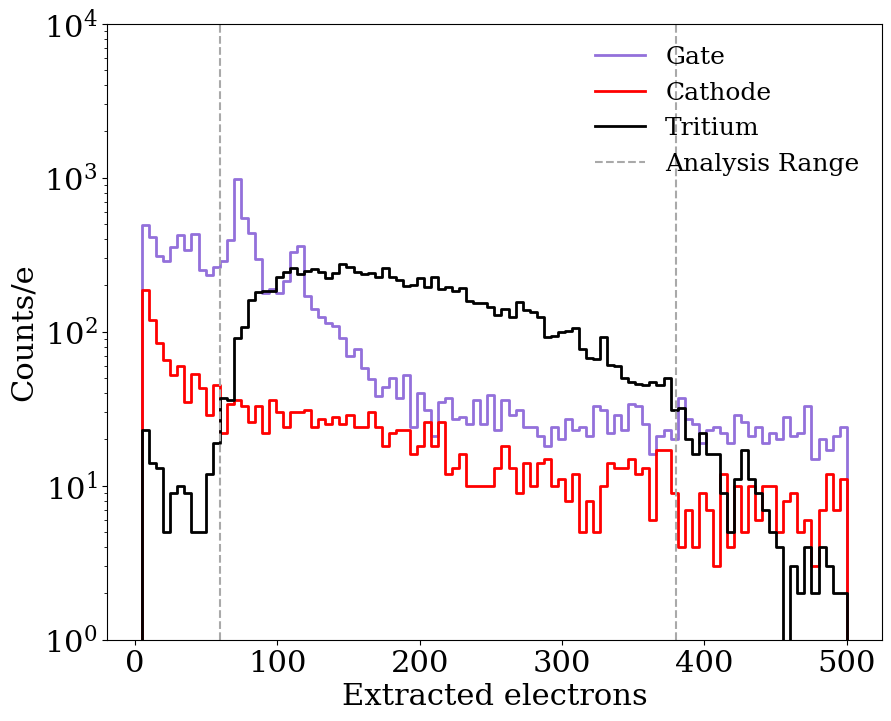

In [471]:
gate_hist = Hist(electron_axis)
gate_cut = df.type == "gate"
gate_hist.fill(df.ext_elec[gate_cut])

cath_hist = Hist(electron_axis)
cath_cut = df.type == "cathode"
cath_hist.fill(df.ext_elec[cath_cut])

trit_hist = Hist(electron_axis)
trit_cut = df.type == "tritium"
trit_hist.fill(df.ext_elec[trit_cut])

fig, ax = plt.subplots(figsize=(10, 8))
gate_hist.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
cath_hist.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
trit_hist.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)

plt.plot(np.full(5,60), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey', label = 'Analysis Range')
plt.plot(np.full(5,380), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey')


ax.set(xlabel='Extracted electrons',ylabel='Counts/e',yscale='log',ylim=[1,10000])
ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False, fontsize = 18)

plt.show()

In [478]:
# implementing thresholds
thresh_cut = (60 < df.ext_elec) & (df.ext_elec < 380)
df_cut = df[thresh_cut].reset_index().drop('index', axis = 1)

In [530]:
# handscanning the weird cathode data bumps 
S2_cath_cut = (70 < df.ext_elec) & (df.ext_elec < 120)
for ii in range(1,11):
    print('%s\t%s'%(df.runID[S2_cath_cut].to_numpy()[ii], df.eventID[S2_cath_cut].to_numpy()[ii]))
    

8144	59142
8144	59902
8154	86148
8153	136792
8139	32009
8151	66996
8151	67428
8161	96447
8141	65314
8151	114316


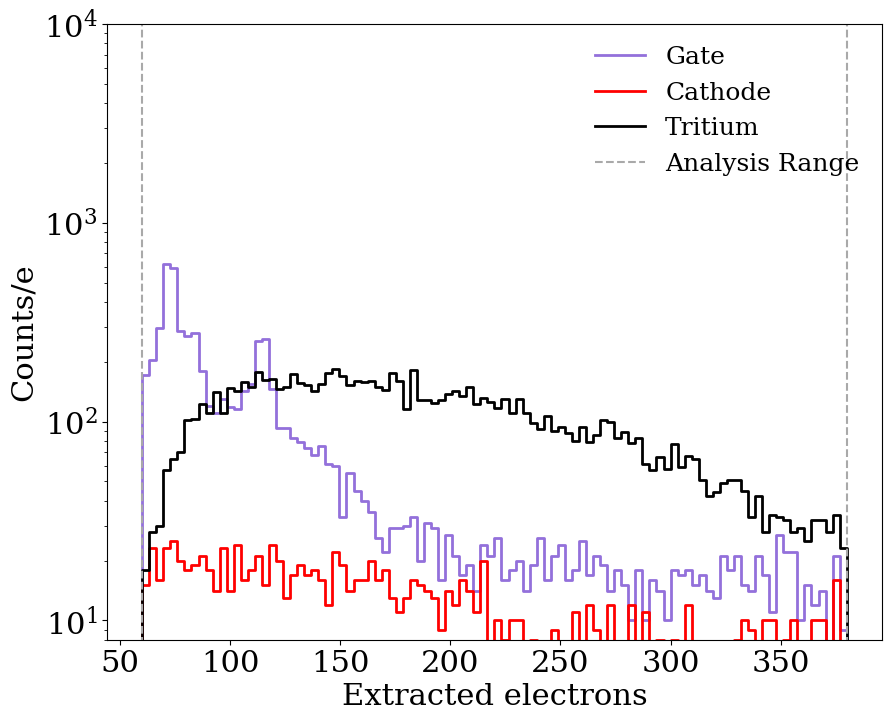

In [479]:
# histogram with threshold data
electron_axis2 = hist.axis.Regular(100,60,380,name="electrons",
                           label="Extracted electrons",flow=False)

gate_hist2 = Hist(electron_axis2)
gate_hist2.fill(df_cut.ext_elec[gate_cut])

cath_hist2 = Hist(electron_axis2)
cath_hist2.fill(df_cut.ext_elec[cath_cut])

trit_hist2 = Hist(electron_axis2)
trit_hist2.fill(df_cut.ext_elec[trit_cut])

fig, ax = plt.subplots(figsize=(10, 8))
gate_hist2.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
cath_hist2.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
trit_hist2.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)

plt.plot(np.full(5,60), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey', label = 'Analysis Range')
plt.plot(np.full(5,380), np.logspace(0, 4, 5), linestyle = '--', color = 'darkgrey')


ax.set(xlabel='Extracted electrons',ylabel='Counts/e',yscale='log',ylim=[8,10000])
ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False, fontsize = 18)

plt.show()

In [480]:
weight_list = []

for ii in range(df_cut.shape[0]):
    if df_cut.type[ii] == 'gate':
        index = np.searchsorted(gate_hist2.to_numpy()[1],df_cut.ext_elec[ii]) - 1
        bin_counts = gate_hist2[index]
    elif df_cut.type[ii] == 'cathode':
        index = np.searchsorted(cath_hist2.to_numpy()[1],df_cut.ext_elec[ii]) - 1
        bin_counts = cath_hist2[index]
    elif df_cut.type[ii] == 'tritium':
        index = np.searchsorted(trit_hist2.to_numpy()[1],df_cut.ext_elec[ii]) - 1
        bin_counts = trit_hist2[index]     
    weight_list.append(1/bin_counts)
        
df_cut['weights'] = weight_list

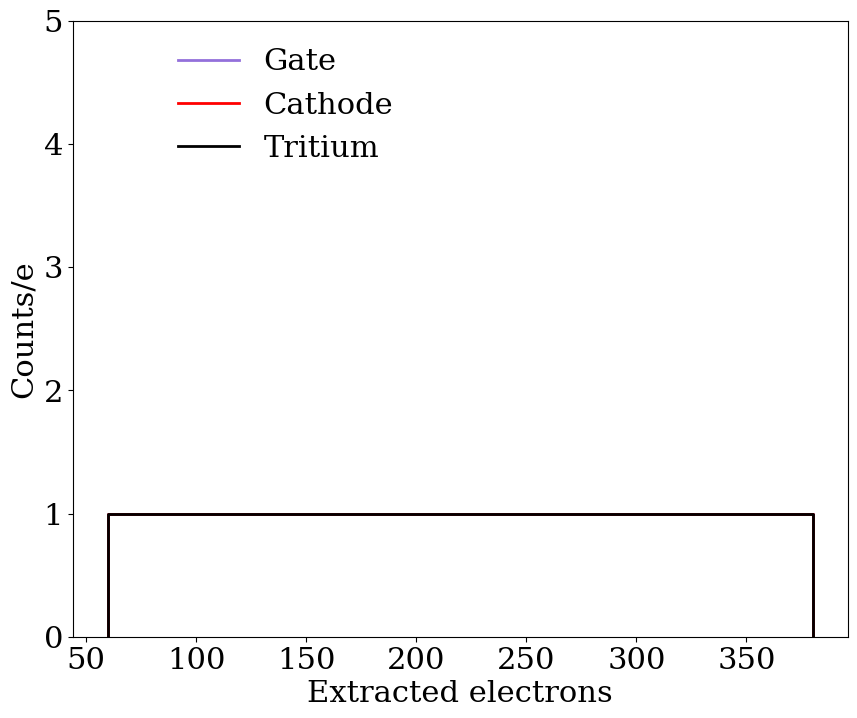

In [481]:
norm_gate_hist = Hist(electron_axis2)
gate_cut = df_cut.type == "gate"
norm_gate_hist.fill(df_cut.ext_elec[gate_cut],weight = df_cut.weights[gate_cut])

norm_cath_hist = Hist(electron_axis2)
cath_cut = df_cut.type == "cathode"
norm_cath_hist.fill(df_cut.ext_elec[cath_cut],weight = df_cut.weights[cath_cut])

norm_trit_hist = Hist(electron_axis2)
trit_cut = df_cut.type == "tritium"
norm_trit_hist.fill(df_cut.ext_elec[trit_cut],weight = df_cut.weights[trit_cut])

fig, ax = plt.subplots(figsize=(10, 8))
norm_gate_hist.plot(color='mediumpurple',ls='-',lw=2,yerr=False,label='Gate',ax=ax)
norm_cath_hist.plot(color='red',ls='-',lw=2,yerr=False,label='Cathode',ax=ax)
norm_trit_hist.plot(color='black',ls='-',lw=2,yerr=False,label='Tritium',ax=ax)

ax.set(xlabel='Extracted electrons',ylabel='Counts/e',ylim=[0,5])
ax.legend(bbox_to_anchor=(0.1,1),loc='upper left',frameon=False)

plt.show()

# Machine learning

### Prepare data for machine learning

In [482]:
df_cut.loc[df["type"] == "tritium", "label"] = 1
df_cut.loc[df["type"] == "gate", "label"] = 0
df_cut.head()

,runID,eventID,area,max_pulse_height,ext_elec,x,y,r,label,type,dt10_05,dt25_10,dt50_25,dt75_50,dt90_75,dt95_90,weights
0,8155,22203,6436.112305,2.266133,136.734912,-45.228909,-22.735205,50.621573,1,tritium,320.0,570.0,680.0,780.0,740.0,380.0,0.006579
1,8155,22291,5628.426270,2.136970,119.575659,10.828576,30.402670,32.273525,1,tritium,360.0,770.0,850.0,740.0,690.0,430.0,0.006098
2,8155,22426,9805.306641,4.920897,208.313292,6.381312,32.306606,32.930806,1,tritium,270.0,480.0,580.0,570.0,510.0,300.0,0.006667
3,8170,57019,6517.310059,2.850476,138.459955,-24.567440,4.934042,25.058010,1,tritium,270.0,550.0,640.0,620.0,580.0,400.0,0.006993
4,8144,58833,13477.413086,6.888328,286.327025,46.079678,19.982748,50.225958,1,tritium,290.0,480.0,530.0,520.0,480.0,300.0,0.012048


In [506]:
features = ['max_pulse_height',
       'dt10_05', 'dt25_10', 'dt50_25', 'dt75_50', 'dt90_75', 'dt95_90',
       'ext_elec']

X = df_cut[features]
Y = df_cut['label']
T = df_cut['type']
W = df_cut['weights'] # - should this be the weight calculated above? 
A = df_cut['area']
R = df_cut['r']
X_raw = df_cut['x']
Y_raw = df_cut['y']
X_train_unscaled, X_test_unscaled, \
Y_train, Y_test, \
A_train, A_test, \
T_train, T_test, \
W_train, W_test, \
R_train, R_test, \
X_raw_train, X_raw_test, \
Y_raw_train, Y_raw_test = \
train_test_split(X, Y, A, T, W, R, X_raw, Y_raw, random_state=0)

In [507]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_unscaled.astype('float64'))
X_test = scaler.transform(X_test_unscaled.astype('float64'))
E_test = A_test/SE_size

### Adaptively boosted decision tree

In [508]:
DTC = DecisionTreeClassifier(max_depth=2,min_samples_split=2)
ABC = AdaBoostClassifier(base_estimator=DTC,n_estimators=100,algorithm = 'SAMME')
model = ABC.fit(X_train, Y_train.values.ravel()
                ,sample_weight=W_train.values.ravel().astype('float64'))

Y_score = model.decision_function(X_test)

model.score(X_train, Y_train, sample_weight=W_train.astype('float64')), \
model.score(X_test, Y_test, sample_weight=W_test.astype('float64')) 

C:\Users\lizzi\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


(0.7273105707396545, 0.72033918217682)

# Understanding machine learning

In [450]:
bin_labels = ['Total', r'60 < $n_e$ < 100', r'100 < $n_e$ < 140', r'140 < $n_e$ < 180', r'180 < $n_e$ < 220',
              r'220 < $n_e$ < 240', r'240 < $n_e$ < 280', r'280 < $n_e$ < 320', r'320 < $n_e$ < 380']
bin_colors = ["black", "purple", "darkblue", "cyan", "green", "gold", "orange", "red", "hotpink"  ]

In [451]:
test_error_list = []
start = 60
for i in range(8):
    test_error = [ ]
    bin_cut = (start < E_test) & (E_test < start + 40)
    start += 40
    for test_predict in model.staged_predict(X_test[bin_cut]):
        test_error.append(1.-accuracy_score(test_predict,Y_test[bin_cut],sample_weight=W_test[bin_cut].ravel().astype('float64')))
    test_error_list.append(test_error)

Text(0, 0.5, 'Test Error')

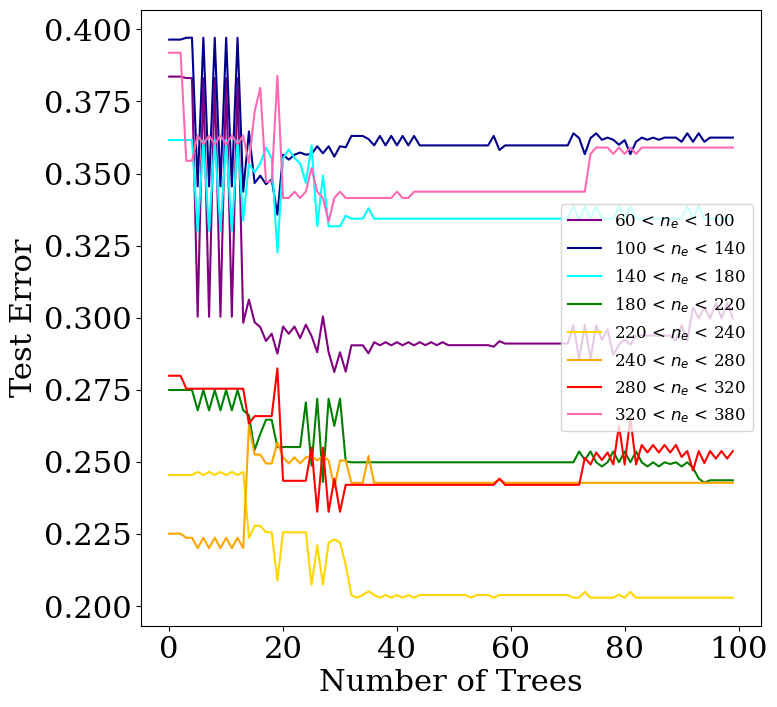

In [452]:
fig, ax = plt.subplots(figsize=(8,8))
for i in range(8):
    ax.plot(test_error_list[i], color = bin_colors[i+1], label=bin_labels[i+1])
ax.legend(fontsize = 12)
ax.set_xlabel('Number of Trees')
ax.set_ylabel('Test Error')

# Results

In [453]:
FPR_T, TPR_T, TH_T = roc_curve(Y_test,Y_score,sample_weight = W_test, pos_label = 1)

In [454]:
TH

array([        inf,  0.59616791,  0.59181143,  0.58000944,  0.56397713,
        0.56260098,  0.55217514,  0.53327471,  0.52766824,  0.52390395,
        0.5172424 ,  0.51586625,  0.50544041,  0.5027336 ,  0.48803195,
        0.45237455,  0.44738526,  0.43558327,  0.42245062,  0.4166843 ,
        0.39927584,  0.39261189,  0.38732432,  0.35412841,  0.35036977,
        0.28564742,  0.27525058,  0.27036841,  0.25502098,  0.2279199 ,
        0.21990224,  0.20648791,  0.18010016,  0.17985768,  0.16980748,
        0.1647206 ,  0.15421827,  0.13921901,  0.1180177 ,  0.11349592,
        0.10711887,  0.09745102,  0.09667551,  0.07751652,  0.06954275,
        0.06092136,  0.05774077,  0.03833262,  0.03119295, -0.00457414,
       -0.00525502, -0.00563279, -0.00635646, -0.02098164, -0.02802926,
       -0.02861365, -0.05250644, -0.05280668, -0.05445337, -0.05539147,
       -0.07111758, -0.08033083, -0.08179875, -0.08380614, -0.09426033,
       -0.09701862, -0.1086937 , -0.11311049, -0.1184735 , -0.11

In [455]:
type(TPR)

numpy.ndarray

In [456]:
Y_score

array([ 0.00858638,  0.24671654,  0.34487089, ...,  0.19646883,
        0.24561364, -0.15918118])

# Bins for ROC curves 

- Full range (60-380)
- For now will do evenly spaced bins i.e:
60-100
100-140
140-180
180-220
220-260
260-300
300-340
340-380


In [457]:
E_test = A_test/SE_size

In [458]:
#bin1 = (60 < E_test) & (E_test < 100) 
#bin2 = (100 < E_test) & (E_test < 140) 
#bin3 = (140 < E_test) & (E_test < 180) 
#bin4 = (180 < E_test) & (E_test < 220) 
#bin5 = (220 < E_test) & (E_test < 260) 
#bin6 = (260 < E_test) & (E_test < 300) 
#bin7 = (300 < E_test) & (E_test < 340) 
#bin8 = (340 < E_test) & (E_test < 380) 
#bin_cuts = [[], bin1, bin2, bin3, bin4, bin5, bin6, bin7, bin8] - keeping these unless I want to do uneven binning


In [496]:
ROC_params_list = [[FPR_T, TPR_T, TH_T]]
start = 60
for i in range(8): 
    bin_cut = (start < E_test) & (E_test < start + 40)
    start += 40
    Y_score = model.decision_function(X_test)
    FPR, TPR, TH = roc_curve(Y_test[bin_cut],Y_score[bin_cut],sample_weight = W_test[bin_cut], pos_label = 1)
    ROC_params_list.append([FPR, TPR, TH])
   

In [498]:
# Finding max efficiency ratio 
def eff_calc(e_s, e_b):
        return np.divide(e_s, np.sqrt(e_b), out=np.zeros_like(e_s), where=e_b!=0)
maxes = []
ratios_list = []
for i in range(9):
    ratios = eff_calc(ROC_params_list[i][1], ROC_params_list[i][0])
    ratios_list.append(ratios)
    ind = np.where(ratios == np.max(ratios))
    maxes.append([ROC_params_list[i][1][ind], ROC_params_list[i][0][ind]])
    

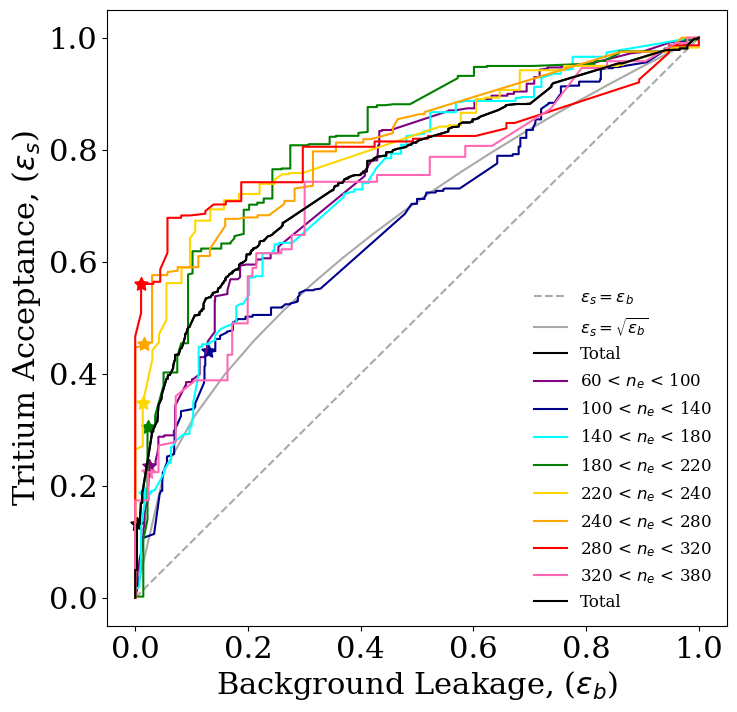

In [499]:
e_s = np.linspace(0, 1, 20)
e_b = np.linspace(0, 1, 20)
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(e_s,e_b, color = 'darkgray', linestyle = '--', label = r'$\epsilon_s = \epsilon_b$')
ax.plot(e_s, eff_calc(e_s,e_b), color = 'darkgray', label = r'$\epsilon_s = \sqrt{\epsilon_b}$')
for i in range(9):
    ax.plot(ROC_params_list[i][0], ROC_params_list[i][1], label = bin_labels[i], color = bin_colors[i])
    ax.scatter(maxes[i][1], maxes[i][0], color = bin_colors[i], s = 100, marker = (5,1))
ax.set_xlabel(r'Background Leakage, ($\epsilon_b$)')
ax.set_ylabel(r'Tritium Acceptance, ($\epsilon_s$)')
ax.plot(FPR_T, TPR_T, color = 'black', label = 'Total')
ax.legend(bbox_to_anchor=(1,0),loc='lower right',frameon=False, fontsize = 12)


In [515]:
# splitting into gate and cathode
ROC_params_gate = []
ROC_params_cath = []
start = 60
for i in range(8): 
    bin_cut = (start < E_test) & (E_test < start + 40)
    start += 40
    gate_cut_ =  T_test != 'cathode' 
    FPR, TPR, TH = roc_curve(Y_test[bin_cut&gate_cut_],Y_score[bin_cut&gate_cut_],sample_weight = W_test[bin_cut&gate_cut_], pos_label = 1)
    ROC_params_gate.append([FPR, TPR, TH])
    cath_cut_ =  T_test != 'gate' 
    FPR, TPR, TH = roc_curve(Y_test[bin_cut&cath_cut_],Y_score[bin_cut&cath_cut_],sample_weight = W_test[bin_cut&cath_cut_], pos_label = 1)
    ROC_params_cath.append([FPR, TPR, TH])


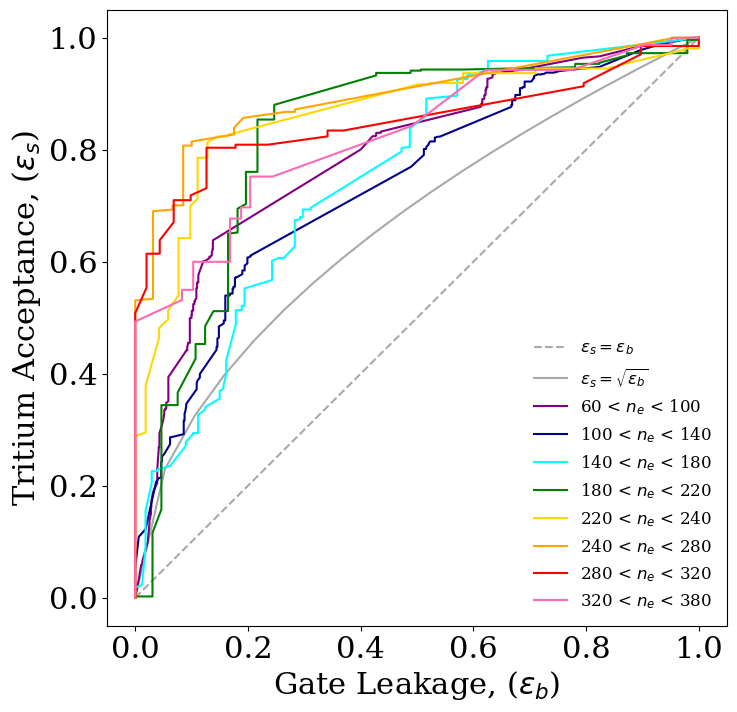

In [516]:
e_s = np.linspace(0, 1, 20)
e_b = np.linspace(0, 1, 20)
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(e_s,e_b, color = 'darkgray', linestyle = '--', label = r'$\epsilon_s = \epsilon_b$')
ax.plot(e_s, eff_calc(e_s,e_b), color = 'darkgray', label = r'$\epsilon_s = \sqrt{\epsilon_b}$')
for i in range(8):
    ax.plot(ROC_params_gate[i][0], ROC_params_gate[i][1], label = bin_labels[i+1], color = bin_colors[i+1])
    #ax.scatter(maxes[i][1], maxes[i][0], color = bin_colors[i], s = 100, marker = (5,1))
ax.set_xlabel(r'Gate Leakage, ($\epsilon_b$)')
ax.set_ylabel(r'Tritium Acceptance, ($\epsilon_s$)')
#ax.plot(FPR_T, TPR_T, color = 'black', label = 'Total')
ax.legend(bbox_to_anchor=(1,0),loc='lower right',frameon=False, fontsize = 12)

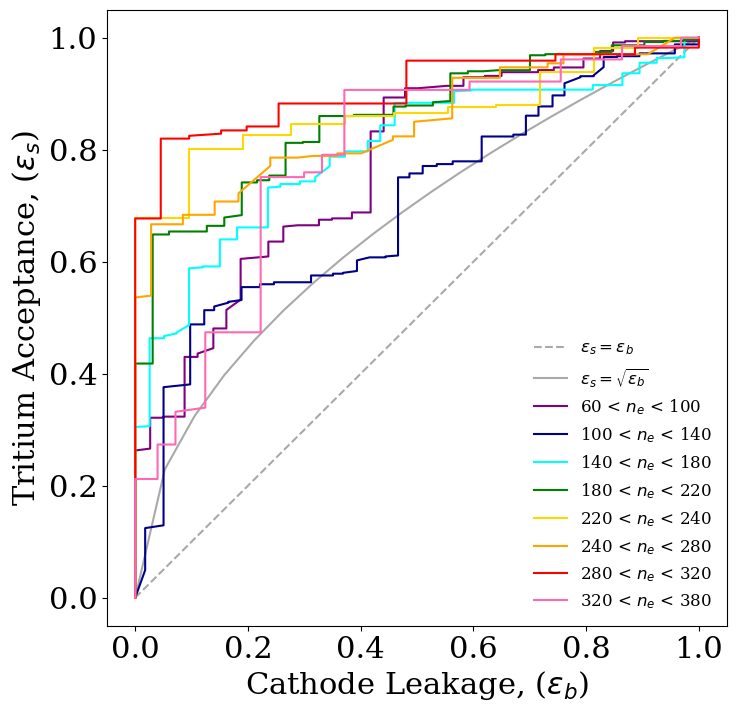

In [517]:
e_s = np.linspace(0, 1, 20)
e_b = np.linspace(0, 1, 20)
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(e_s,e_b, color = 'darkgray', linestyle = '--', label = r'$\epsilon_s = \epsilon_b$')
ax.plot(e_s, eff_calc(e_s,e_b), color = 'darkgray', label = r'$\epsilon_s = \sqrt{\epsilon_b}$')
for i in range(8):
    ax.plot(ROC_params_cath[i][0], ROC_params_cath[i][1], label = bin_labels[i+1], color = bin_colors[i+1])
    #ax.scatter(maxes[i][1], maxes[i][0], color = bin_colors[i], s = 100, marker = (5,1))
ax.set_xlabel(r'Cathode Leakage, ($\epsilon_b$)')
ax.set_ylabel(r'Tritium Acceptance, ($\epsilon_s$)')
#ax.plot(FPR_T, TPR_T, color = 'black', label = 'Total')
ax.legend(bbox_to_anchor=(1,0),loc='lower right',frameon=False, fontsize = 12)